# Predicting Boston Housing Prices

**Goal:**
In this project, we will evaluate the performance and predictive power of a model that has been trained and tested on data collected from homes in suburbs of Boston, Massachusetts. A model trained on this data that is seen as a *good fit* could then be used to make certain predictions about a home's monetary value.

**Dataset:**
The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). The Boston housing data was collected in 1978 and each of the 506 entries represent aggregated data about 14 features for homes from various suburbs in Boston, Massachusetts. 

For the purposes of this project, the following preprocessing steps have been made to the dataset:
- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed.
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- The features `'RM'`, `'LSTAT'`, `'PTRATIO'`, and `'MEDV'` are essential. The remaining **non-relevant features** have been excluded.
- The feature `'MEDV'` has been **multiplicatively scaled** to account for 35 years of market inflation.

We'll start with the reading in the data, and separating the features and prices for homes into different pandas dataframes. 

In [8]:
###########################################
#Import Required Libraries

import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
from sklearn.model_selection import learning_curve as curves
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split

# Suppress matplotlib user warnings
import warnings
warnings.filterwarnings('ignore')


# To display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
###########################################


In [11]:
# Load the Boston housing dataset
data = pd.read_csv('housing.csv')
prices = data['MEDV']
features = data.drop('MEDV', axis = 1)
    
# Success
print ('Boston housing dataset has {} data points with {} variables each'.format(*data.shape))

Boston housing dataset has 489 data points with 4 variables each


## Data Exploration
In this section, we will make a cursory investigation about the Boston housing data.

Since the main goal of this project is to construct a working model which has the capability of predicting the value of houses, we have separated the dataset into **features** and the **target variable**. The **features**, `'RM'`, `'LSTAT'`, and `'PTRATIO'`, give us quantitative information about each data point. The **target variable**, `'MEDV'`, will be the variable we seek to predict. These are stored in `features` and `prices`, respectively.

### Calculating Statistics

We'll start with calculating some descriptive statistics about the Boston housing prices.

In [13]:
# Minimum price of the data
minimum_price = np.min(prices)

# Maximum price of the data
maximum_price = np.max(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105000.0
Maximum price: $1024800.0
Mean price: $454342.9447852761
Median price $438900.0
Standard deviation of prices: $165171.13154429477


### Feature Observation

To dive a bit deeper int our data, we are using three features from the Boston housing dataset: `'RM'`, `'LSTAT'`, and `'PTRATIO'`. For each data point (neighborhood):
- `'RM'` is the average number of rooms among homes in the neighborhood.
- `'LSTAT'` is the percentage of homeowners in the neighborhood considered "lower class" (working poor).
- `'PTRATIO'` is the ratio of students to teachers in primary and secondary schools in the neighborhood.

Without building a model, let's try to figure out if an increase in the value of a feature would lead to an **increase** in the value of `'MEDV'` or a **decrease** in the value of `'MEDV'`.

We can build scatterplots to see if our intuition is correct.

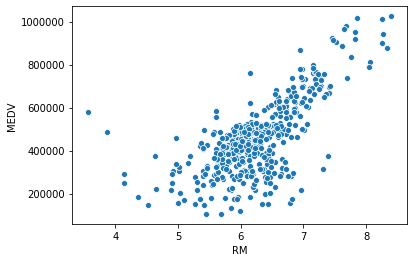

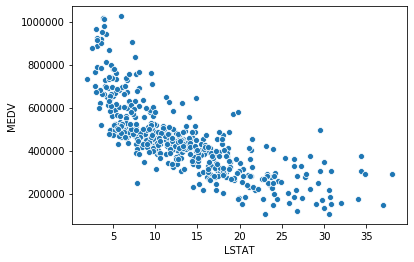

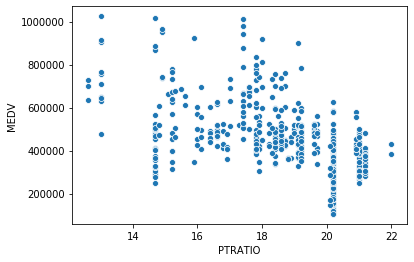

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

for var in features.columns:
    sns.scatterplot(data[var],prices)
    plt.show()

Conclusion drawn from the above analysis:

- **'RM':** An increase in the value of this feature will lead to an increase in the value of 'MEDV'. This is because for you'd expect a home with a higher number of rooms to be more expensive that a home with lower number of rooms. 
- **'LSTAT':** An increase in the value of this feature will lead to a decrease in the value of 'MEDV'. A lower class homeowner might not be able to afford expensive houses, so you'd expect them to leave in a cheaper home. A higher percentage of such people could correlate to cheaper homes in an area, and thus, a lower 'MEDV' value.
- **'PTRATIO':** The data is scattered a bit. It can be thought that, an increase in the value of this feature will lead to an decrease in the value of 'MEDV'. Neighborhoods with more students to teachers ratio (higher 'PTRATIO' value) will be worth less. If the percentage of students to teachers ratio people is higher, it is likely that in the neighborhood there are less schools. And, due to the presence of better quality schools or more number of schools, people might be willing to pay more to live in those areas, to provide their children with better education, and the prices might be higher.


----

## Developing a Model
In this section of the project, we will develop the tools and techniques necessary for a model to make a prediction. Being able to make accurate evaluations of each model's performance through the use of these tools and techniques helps to greatly reinforce the confidence in your predictions.

### Implementation: Define a Performance Metric
For this project, we will calculate the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify our model's performance. The coefficient of determination for a model is a useful statistic in regression analysis, as it often describes how "good" that model is at making predictions. 

The values for R<sup>2</sup> range from 0 to 1, which captures the percentage of squared correlation between the predicted and actual values of the **target variable**. 
- A model with an R<sup>2</sup> of 0 is no better than a model that always predicts the *mean* of the target variable, 
- whereas a model with an R<sup>2</sup> of 1 perfectly predicts the target variable. 
- Any value between 0 and 1 indicates what percentage of the target variable, using this model, can be explained by the **features**.

Let's define a function that returns the r2 score for given true and predicted data.

In [21]:
# Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true,y_predict)
    
    # Return the score
    return score

### Split Data for Training and Testing

Now we'll take the Boston housing dataset and split the data into training and testing subsets. Typically, the data is also shuffled into a random order when creating the training and testing subsets to remove any bias in the ordering of the dataset.

In [27]:
# Shuffle and split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(features,prices,test_size=0.2,random_state=100)

By spitting a dataset into training and testing subsets, we can train our model on the training subset, and then feed it with unseen data from the test subset to evaluate the performance of our model. 

Training and testing on the same data doesn't give us a genuine evaluation of the model, at it has already seen testing the data when training, and thus might not perform well in real-world scenarios where we often deal with unseen data. Related to this is the problem of "overfitting", i.e. the model can be really accurate on the training data, but perform poorly on the training data. 

----

## Analyzing Model Performance
In this third section of the project, we'll take a look at several models' learning and testing performances on various subsets of training data. Additionally, we'll investigate the Decision Tree algorithm with an increasing `'max_depth'` parameter on the full training set to observe how model complexity affects performance. 

In [38]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
def ModelLearning(X, y):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing scores for each model are then plotted. """

    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Generate the training set sizes increasing by 50
    train_sizes = np.rint(np.linspace(1, X.shape[0]*0.8 - 1, 9)).astype(int)

    # Create the figure window
    fig = pl.figure(figsize=(10,7))

    # Create three different models based on max_depth
    for k, depth in enumerate([1,3,6,10]):

        # Create a Decision tree regressor at max_depth = depth
        regressor = DecisionTreeRegressor(max_depth = depth)

        # Calculate the training and testing scores
        sizes, train_scores, test_scores = learning_curve(regressor, X, y, \
            cv = cv, train_sizes = train_sizes, scoring = 'r2')

        # Find the mean and standard deviation for smoothing
        train_std = np.std(train_scores, axis = 1)
        train_mean = np.mean(train_scores, axis = 1)
        test_std = np.std(test_scores, axis = 1)
        test_mean = np.mean(test_scores, axis = 1)

        # Subplot the learning curve
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, train_mean, 'o-', color = 'r', label = 'Training Score')
        ax.plot(sizes, test_mean, 'o-', color = 'g', label = 'Testing Score')
        ax.fill_between(sizes, train_mean - train_std, \
            train_mean + train_std, alpha = 0.15, color = 'r')
        ax.fill_between(sizes, test_mean - test_std, \
            test_mean + test_std, alpha = 0.15, color = 'g')

        # Labels
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Training Points')
        ax.set_ylabel('Score')
        ax.set_xlim([0, X.shape[0]*0.8])
        ax.set_ylim([-0.05, 1.05])

    # Visual aesthetics
    ax.legend(bbox_to_anchor=(1.05, 2.05), loc='lower left', borderaxespad = 0.)
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize = 16, y = 1.03)
    fig.tight_layout()
    fig.show()


def ModelComplexity(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """

    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

    # Vary the max_depth parameter from 1 to 10
    max_depth = np.arange(1,11)

    # Calculate the training and testing scores
    train_scores, test_scores = validation_curve(DecisionTreeRegressor(), X, y, \
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    pl.figure(figsize=(7, 5))
    pl.title('Decision Tree Regressor Complexity Performance')
    pl.plot(max_depth, train_mean, 'o-', color = 'r', label = 'Training Score')
    pl.plot(max_depth, test_mean, 'o-', color = 'g', label = 'Validation Score')
    pl.fill_between(max_depth, train_mean - train_std, \
        train_mean + train_std, alpha = 0.15, color = 'r')
    pl.fill_between(max_depth, test_mean - test_std, \
        test_mean + test_std, alpha = 0.15, color = 'g')

    # Visual aesthetics
    pl.legend(loc = 'lower right')
    pl.xlabel('Maximum Depth')
    pl.ylabel('Score')
    pl.ylim([-0.05,1.05])
    pl.show()


def PredictTrials(X, y, fitter, data):
    """ Performs trials of fitting and predicting data. """

    # Store the predicted prices
    prices = []

    for k in range(10):
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, \
            test_size = 0.2, random_state = k)

        # Fit the data
        reg = fitter(X_train, y_train)

        # Make a prediction
        pred = reg.predict([data[0]])[0]
        prices.append(pred)

        # Result
        print("Trial {}: ${:,.2f}".format(k+1, pred))

    # Display price range
    print ('\nRange in prices: ${:,.2f}'.format(max(prices) - min(prices)))

### Learning Curves
The following code cell produces four graphs for a decision tree model with different maximum depths. Each graph visualizes the learning curves of the model for both training and testing as the size of the training set is increased. The shaded region of a learning curve denotes the uncertainty of that curve (measured as the standard deviation). The model is scored on both the training and testing sets using R<sup>2</sup>, the coefficient of determination.  

_Note: The section uses helper functions supplied for the purposes of this project and available in the 'visuals' module.

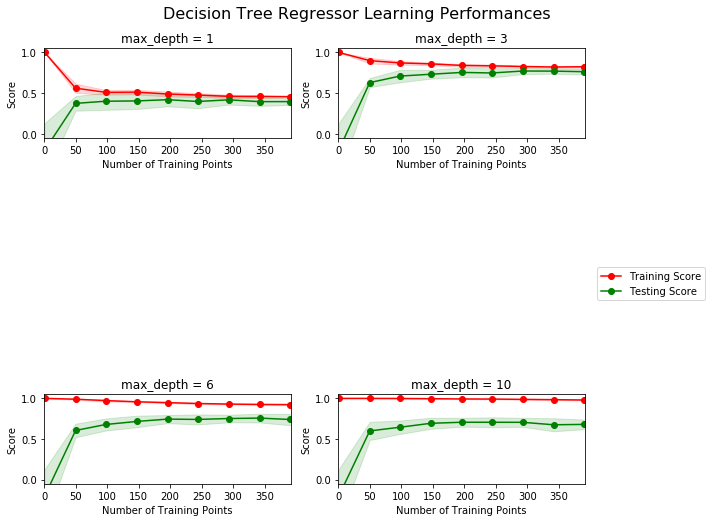

In [37]:
# Produce learning curves for varying training set sizes and maximum depths
ModelLearning(features, prices)

Looking at the learning curve for the model with max_depth = 3, 

- The score of the training curve decreases as more training points are added. This happens because with fewer training points, the model can modify its paramters to better approximate the targets; but as the number of training points increases, perfectly fitting them becomes more difficult, and the training score goes down. 
- The score of the training curve increases as more training points are added, but there's a slight dip after adding more than 350 training points. The score starts lower because the model has not yet learned enough to predict test points. As the model receives more training points, and hence, more information, it is better suited to predict unseen data.
- The training and testing curve seem to be converging to a score of 0.8. This usually happens when the model has stretched its limits of extracting information from the training data even though more training points are being added. So the score stabilizes.

Therefore, having more training points might not benefit the model (with max_depth of 3).

### Complexity Curves
The following code cell produces a graph for a decision tree model that has been trained and validated on the training data using different maximum depths. The graph produces two complexity curves — one for training and one for validation. Similar to the **learning curves**, the shaded regions of both the complexity curves denote the uncertainty in those curves, and the model is scored on both the training and validation sets using the `performance_metric` function.  

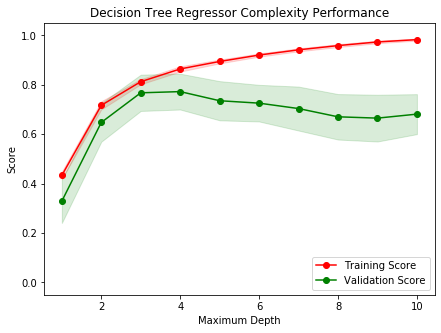

In [39]:
ModelComplexity(X_train, y_train)

### Bias-Variance Tradeoff


- Model trained with max_depth of 1: The model suffers from high bias at this depth. Looking at the graph, we can see that both training and validation scores are low, and similar. We can say that the model is over-simplified and is not capturing the underlying relationships present in the data for both training and validation datasets. 

- Model trained with max_depth of 10: The model suffers from high variance at this depth, and is overfitting on the training data. In the graph, we can see that the training score at this depth is almost equal to 1.0, while the validation score is lower, at around 0.7. The curves also seem to be diverging away from each other at this point.



#### Optimal Model - Guess

In my opinion, a maximum depth of 3 results in a model that best generalizes to unseen data. That depth is the sweet spot for model complexity, as our model performs similar on training and validation data, while the overall score for both is still relatively high at between 0.7 to 0.8. 

In addition,a depth lower than that gives us poor training and validation score, while a higher depth overfits on the testing data, leading to a lower validation score.

-----

## Evaluating Model Performance
In this final section of the project, we will construct a model and make a prediction on the client's feature set using an optimized model from `fit_model`.

We'll be using **Grid Search** and **Cross Validation** techniques in this section.

### Grid Search

The grid search technique is a systematic way of going through different combinations of parameter values while cross validating the results to determine the parameter combination which gives the best performance based on a scoring technique.

In order to optimize a learning algorithm, we can apply grid search by specifying the parameters, and the possible values of those parameters. The grid search then returns the best parameter values for our model, after fitting the supplied data. This takes out the guess-work involved in seeking out the opitimal paramter values for a classifier.

### Cross-Validation

The k-fold crossvalidation training technique is a way of splitting the dataset into *k* partitions of equal size, and then running *k* separate learning experiments on the training data. In each of the experiments, we chose a training set of the size of k-1 partitions, train our model on that partition, and evaluate the results on the remaining test data. The results/scores for the k experiments are then averaged out. 

This technique is benefitial when using grid search to optimize a model because it allows us to look for parameter settings that perform well for different test sets. If we had a single testing set, it's easy to tune a model to perform well for that specific test set (and result in overfitting on the test set in this case), while cross validation allows us to generalize the results.

### Fitting a Model

Now we'll bring everything together and train a model using the **decision tree algorithm**. To ensure that we are producing an optimized model, we will train the model using the grid search technique to optimize the `'max_depth'` parameter for the decision tree. The `'max_depth'` parameter can be thought of as how many questions the decision tree algorithm is allowed to ask about the data before making a prediction.

In [41]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[1,2,3,4,5,6,7,8,9,10]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    # Make sure to include the right parameters in the object:
    # (estimator, param_grid, scoring, cv) which have values 'regressor', 'params', 'scoring_fnc', and 'cv_sets' respectively.
    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

### Making Predictions
Once a model has been trained on a given set of data, it can be used to make predictions on new sets of input data. In the case of a *decision tree regressor*, the model has learned *what the best questions to ask about the input data are*, and can respond with a prediction for the **target variable**.

### Optimal Model

In [42]:
# Fit the training data to the model using grid search
reg = fit_model(X_train, y_train)

# Produce the value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth']))

Parameter 'max_depth' is 4 for the optimal model.


**Answer: ** The optimal model has a max depth of 4, which is close enough to the previous guess of 3 earlier. Going back to the complexity graph, the model might perform better on the test set with a max depth of 4, but since the difference is minimal (which can also be due to noise), it might make sense to chose the simpler model. 

### Predicting Selling Prices

Imagine that you were a real estate agent in the Boston area looking to use this model to help price homes owned by your clients that they wish to sell. You have collected the following information from three of your clients:

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

Let's see what prices our model will predict for these clients, and if they seem reasonable given the features.

In [43]:
# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3

# Show predictions
for i, price in enumerate(reg.predict(client_data)):
    print("Predicted selling price for Client {}'s home: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home: $401,333.33
Predicted selling price for Client 2's home: $240,947.37
Predicted selling price for Client 3's home: $893,700.00


The prices seem reasonable given the features of the homes. We can see that the highest priced home has the most rooms, lowest neighbourhood poverty level, and the lowest student-teacher ratio, 
On the contrary, the home with the lowest number of rooms, highest neighbourhood poverty level, and highest student-teacher ratio is priced the lowest in our predictions.

## Conclusion

Now, we use these results to discuss whether the constructed model should or should not be used in a real-world setting. Some questions that are worth to answer:
- How relevant today is data that was collected from 1978? How important is inflation?
- Are the features present in the data sufficient to describe a home? Do you think factors like quality of apppliances in the home, square feet of the plot area, presence of pool or not etc should factor in?
- Is the model robust enough to make consistent predictions?
- Would data collected in an urban city like Boston be applicable in a rural city?
- Is it fair to judge the price of an individual home based on the characteristics of the entire neighborhood?

**Answers**

- Data collected from 1978 is not of much value in today's world, society and economics have changed so much and in addtion, inflation has made a great impact on the prices.
- The dataset considered is quite limited, there are a lot of features like *the size of the house in square feet*, *availability of pool or not*, *proximity to city center*, or *neighbourhood crime rate*. and others, that are very relevant when considering a house price.
- Given the high variance on the prince range, we can assure that it is not a robust model and, therefore, not appropiate for making predictions.
- The data collected in an urban city will not be applicable in a rural city, because the people might value different aspects of a home depending on whether they live in an urban city or a rural area. For example, a person living in a rural city might value number of rooms in a home over the proximity to the city.
- In general it is not fair to estimate or predict the price of an indivual home based on the features of the entire neighborhood. In the same neighborhood there can be huge differences in prices.